<a href="https://colab.research.google.com/github/YoonSuYeon/Biometric_Security/blob/main/hw5_fingerprint_2171092_%EC%9C%A4%EC%88%98%EC%97%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
import math
from tqdm.notebook import tqdm

# import fingerprint as fp

## EASY

In [2]:
train_path = '/content/drive/MyDrive/EWHA/train/train_ref'
test2_path = '/content/drive/MyDrive/EWHA/test2/test2'


list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test2))

477 1428


/content/drive/MyDrive/EWHA/test2/test2/100_type1.BMP 100 /content/drive/MyDrive/EWHA/train/train_ref/100.BMP


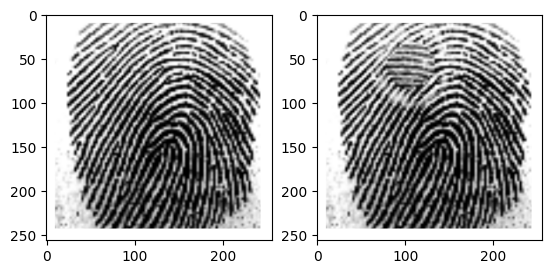

In [3]:
target_path = list_test2[0]
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
print(target_path, basename, train_sample_path)
img_train = cv2.imread(train_sample_path, 0)
img_test = cv2.imread(target_path, 0)

plt.subplot(1,2,1)
plt.imshow(img_train, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_test, cmap='gray')

In [4]:
from skimage.morphology import skeletonize
from skimage.util import invert

def get_fp_feature(img, flg_show=False):
    # 1. 원본 복사
    img_orig = img.copy()


    # 3. CLAHE (대비 향상)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_orig)

    # 4. Unsharp Masking (선 강조)
    blur = cv2.GaussianBlur(img_clahe, (5, 5), 1.0)
    img_proc = cv2.addWeighted(img_clahe, 1.3, blur, -0.3, 0)

    # 5. 이진화 (Otsu)
    _, binary = cv2.threshold(img_proc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 6. Morphological Closing (선 연결)
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 2. 색 반전
    img_rev = 255 - binary

    # 7. 마스크 생성 및 적용 (배경 제거)
    mask = cv2.morphologyEx(img_rev, cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    mask = cv2.GaussianBlur(mask, (33, 33), 0)
    cleaned = cv2.bitwise_and(img_rev, img_rev, mask=(mask > 127).astype(np.uint8) * 255)


    # 8. 세선화 (Skeletonization)
    skeleton = skeletonize(cleaned // 255)
    skeleton = (skeleton * 255).astype(np.uint8)

    # 9. Minutiae (끝점 & 분기점 추출)
    feat_end, feat_bif = [], []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:
                block = skeleton[y-1:y+2, x-1:x+2]
                neighbors = np.sum(block == 255) - 1
                if neighbors == 1:
                    feat_end.append((x, y))
                elif neighbors >= 3:
                    feat_bif.append((x, y))

    # 10. 시각화
    if flg_show:
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))

        axs[0, 0].imshow(img_orig, cmap='gray')
        axs[0, 0].set_title('Original Image')

        axs[0, 1].imshow(binary, cmap='gray')
        axs[0, 1].set_title('Binary Image')

        axs[0, 2].imshow(skeleton, cmap='gray')
        axs[0, 2].set_title('Skeleton Image')

        axs[1, 0].imshow(mask, cmap='gray')
        axs[1, 0].set_title('Mask')

        axs[1, 1].imshow(cleaned, cmap='gray')
        axs[1, 1].set_title('Cleaned Image')

        axs[1, 2].imshow(skeleton, cmap='gray')
        if feat_end:
            axs[1, 2].scatter(*zip(*feat_end), c='red', s=10, label='End')
        if feat_bif:
            axs[1, 2].scatter(*zip(*feat_bif), c='blue', s=10, label='Bifurcation')
        axs[1, 2].legend()
        axs[1, 2].set_title('Minutiae extraction results')

        plt.tight_layout()
        plt.show()

    return feat_end, feat_bif


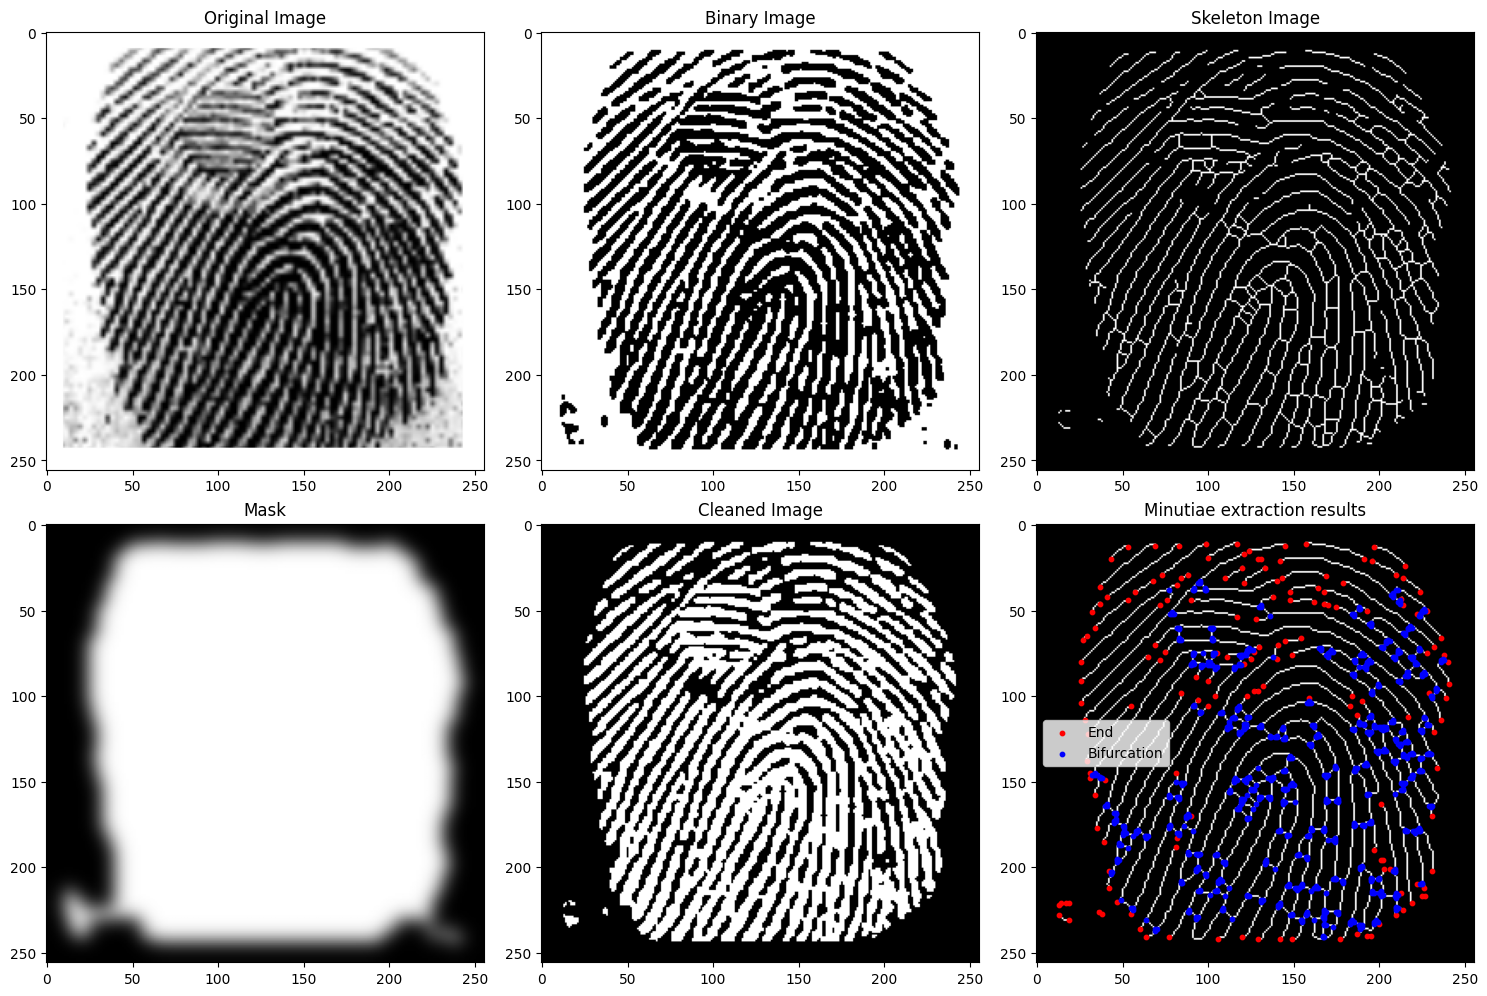

In [5]:
q_end, q_bif = get_fp_feature(img_test, flg_show=True)

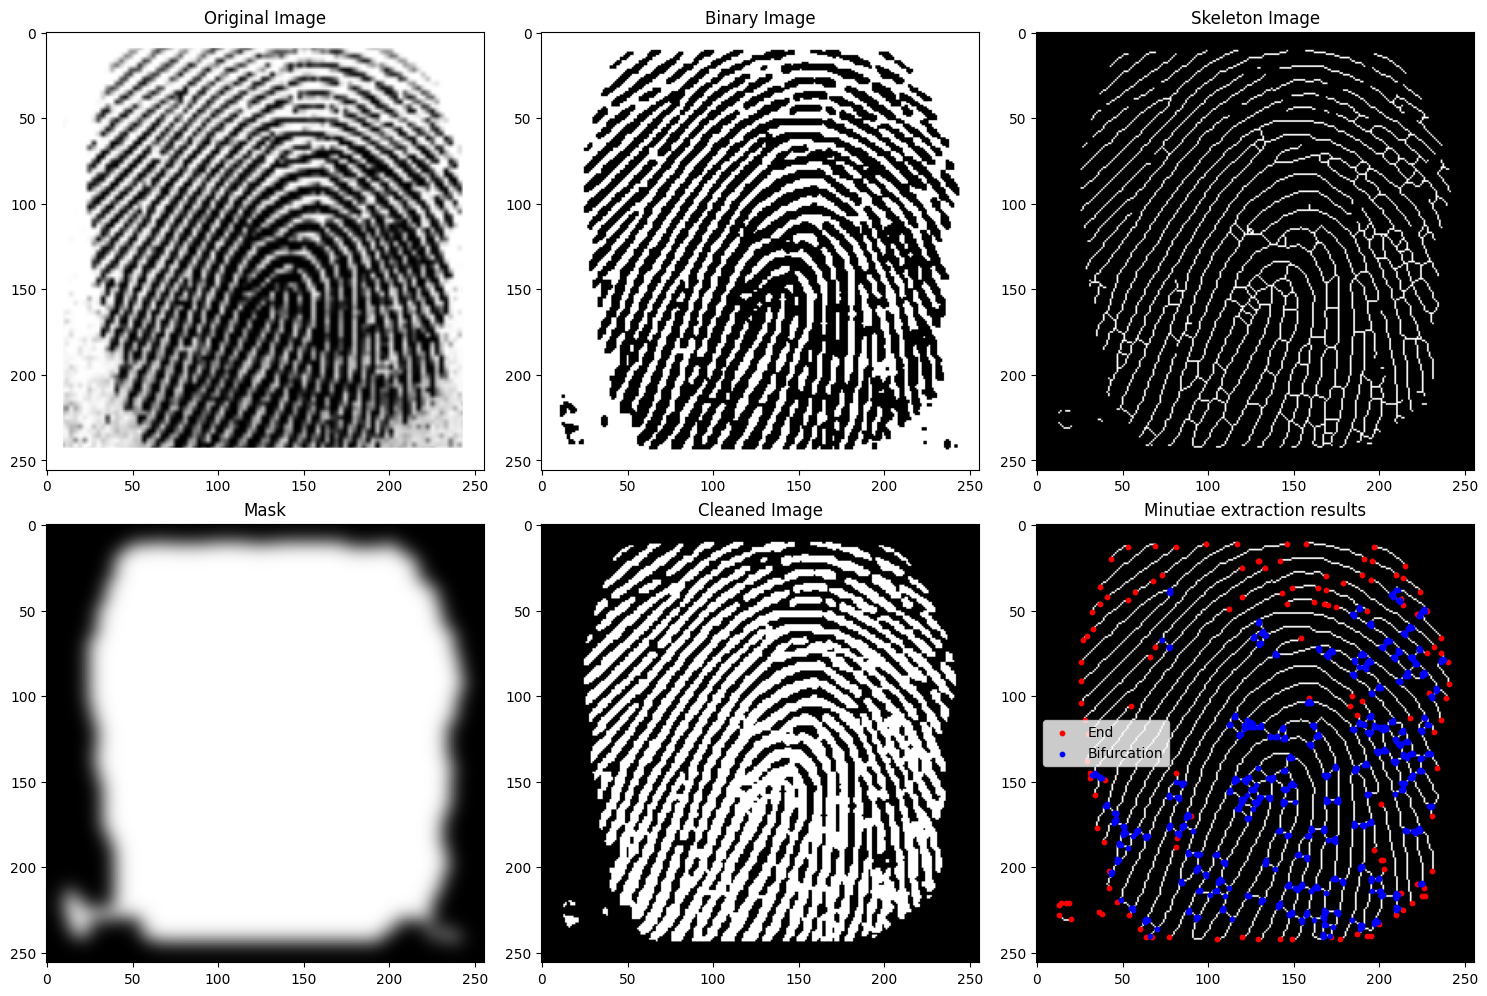

In [6]:
db_end, db_bif = get_fp_feature(img_train, flg_show=True)

In [7]:
feat_query = np.concatenate([q_end, q_bif]).astype(np.uint8)
feat_train = np.concatenate([db_end, db_bif]).astype(np.uint8)

In [8]:
print(type(feat_query))
print(type(feat_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
print(len(feat_query))
print(len(feat_train))

921
834


In [10]:
# def match_finger(feat_query, feat_train, max_points=100, flg_show=False, img_query=None, img_train=None):
#     """
#     두 지문 이미지의 특징점 리스트를 매칭하고 시각화하는 함수.

#     Parameters:
#         feat_query : list of (x, y) — 테스트 이미지의 특징점
#         feat_train : list of (x, y) — 학습 이미지의 특징점
#         max_points : int — 최대 매칭 쌍 개수
#         flg_show : bool — 매칭 시각화 여부
#         img_query : np.ndarray — query 이미지 (grayscale)
#         img_train : np.ndarray — train 이미지 (grayscale)

#     Returns:
#         dist : float — 평균 거리
#         len_match : int — 매칭 수
#     """
#     matches = []
#     for pt1 in feat_query:
#         best_pt2 = None
#         min_dist = float('inf')
#         for pt2 in feat_train:
#             d = np.linalg.norm(np.array(pt1) - np.array(pt2))
#             if d < min_dist:
#                 min_dist = d
#                 best_pt2 = pt2
#         if best_pt2 is not None:
#             matches.append((pt1, best_pt2, min_dist))

#     # 거리 오름차순 정렬 후 top N만 선택
#     matches = sorted(matches, key=lambda x: x[2])[:max_points]
#     distances = [m[2] for m in matches]
#     dist = np.mean(distances)
#     len_match = len(matches)

#     # 시각화
#     if flg_show and img_query is not None and img_train is not None:
#         h, w = img_query.shape
#         canvas = np.ones((h, w * 2), dtype=np.uint8) * 255
#         canvas[:, :w] = img_query
#         canvas[:, w:] = img_train

#         plt.figure(figsize=(12, 6))
#         plt.imshow(canvas, cmap='gray')
#         plt.title("query image                         train image")

#         for (pt1, pt2, _) in matches:
#             x1, y1 = pt1
#             x2, y2 = pt2
#             x2 += w  # 오른쪽으로 이동한 위치

#             color = np.random.rand(3,)
#             plt.plot([x1, x2], [y1, y2], color=color, linewidth=1)
#             plt.scatter(x1, y1, c='red', s=10)    # query 점 (좌측)
#             plt.scatter(x2, y2, c='blue', s=10)   # train 점 (우측)

#         plt.axis('on')
#         plt.show()

#     return dist, len_match


## 매칭

In [11]:
def match_finger(feat_query, feat_train, max_points=100, flg_show=False, img_query=None, img_train=None):
    """
    특징점 리스트 간 매칭 후 subplot 기반 시각화 (query vs train)

    Parameters:
        feat_query : list[(x, y)]
        feat_train : list[(x, y)]
        max_points : int — top N 매칭 개수
        flg_show : bool — 시각화 여부
        img_query : np.ndarray — query grayscale 이미지
        img_train : np.ndarray — train grayscale 이미지

    Returns:
        dist : 평균 거리
        len_match : 매칭 수
    """

    matches = []

    for pt1 in feat_query:
        best_pt2 = None
        min_dist = float('inf')

        for pt2 in feat_train:
            # 원본 튜플(pt1, pt2)은 그대로 두고…
            p_arr = np.array(pt1, dtype=np.float32)
            q_arr = np.array(pt2, dtype=np.float32)
            d     = np.linalg.norm(p_arr - q_arr)

            if d < min_dist:
                min_dist = d
                best_pt2 = pt2
        if best_pt2 is not None:
            # pt1, best_pt2 는 여전히 (x,y) 튜플 상태
            matches.append((pt1, best_pt2, min_dist))

    # 거리 기준 정렬 후 상위 N만
    matches = sorted(matches, key=lambda x: x[2])[:max_points]
    distances = [m[2] for m in matches]

    # 평균 거리 계산
    dist = np.mean(distances) if len(distances) > 0 else float('inf')
    len_match = len(matches)

    # 시각화
    if flg_show and img_query is not None and img_train is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Query 이미지
        ax1.imshow(img_query, cmap='gray')
        ax1.set_title("query image")

        # Train 이미지
        ax2.imshow(img_train, cmap='gray')
        ax2.set_title("train image")

        fig.canvas.draw()

        # subplot transform → figure 좌표계 기준으로 변환
        transFigure = fig.transFigure.inverted()
        ax1_to_fig = ax1.transData.transform
        ax2_to_fig = ax2.transData.transform
        fig_to_ax = fig.transFigure.transform

        for (pt1, pt2, _) in matches:
            # Query 점 (왼쪽 plot 좌표 → figure 좌표 → 다시 display 좌표)
            coord1_disp = ax1_to_fig(pt1)
            coord2_disp = ax2_to_fig(pt2)
            coord1_fig = transFigure.transform(coord1_disp)
            coord2_fig = transFigure.transform(coord2_disp)

            # 랜덤 선 색
            color = np.random.rand(3,)

            # 연결선
            line = plt.Line2D(
                [coord1_fig[0], coord2_fig[0]],
                [coord1_fig[1], coord2_fig[1]],
                transform=fig.transFigure,
                color=color,
                linewidth=1
            )
            fig.lines.append(line)

            # 점 표시
            ax1.scatter(*pt1, c='red', s=10)
            ax2.scatter(*pt2, c='blue', s=10)
            # ax1.scatter(pt1[0], pt1[1], c='red',  s=10)
            # ax2.scatter(pt2[0], pt2[1], c='blue', s=10)

        plt.tight_layout()
        plt.show()

    return dist, len_match


In [12]:
## 2nd
import numpy as np
import matplotlib.pyplot as plt

def match_finger(feat_query, feat_train, max_points=100, flg_show=False,img_query=None,img_train=None):

    # --- 1) 모든 쌍 거리 계산 (dist 목적) ---
    all_distances = []
    for p in feat_query:
        for q in feat_train:
            d = np.linalg.norm(np.array(p, dtype=np.float32) - np.array(q, dtype=np.float32))
            all_distances.append(d)
    dist = float(np.mean(all_distances)) if all_distances else float('inf')

    # --- 2) 가장 가까운 매칭만 추려서 시각화용 매칭 리스트 구성 ---
    matches = []
    for p in feat_query:
        best_d = np.inf
        best_q = None
        for q in feat_train:
            d = np.linalg.norm(np.array(p, dtype=np.float32) - np.array(q, dtype=np.float32))
            if d < best_d:
                best_d = d
                best_q = q
        if best_q is not None:
            matches.append((p, best_q, best_d))

    # 매칭 거리 기준 정렬 후 상위 max_points만 시각화용으로
    matches = sorted(matches, key=lambda x: x[2])[:max_points]
    len_match = len(matches)


    # 3) 시각화
    if flg_show and img_query is not None and img_train is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.imshow(img_query, cmap='gray'); ax1.set_title("query image")
        ax2.imshow(img_train, cmap='gray'); ax2.set_title("train image")
        fig.canvas.draw()

        # 좌표계 변환 준비
        trans_fig = fig.transFigure.inverted()
        to_fig1   = ax1.transData.transform
        to_fig2   = ax2.transData.transform

        for (p, q, _) in matches:
            c1_disp = to_fig1(p)
            c2_disp = to_fig2(q)
            c1_fig  = trans_fig.transform(c1_disp)
            c2_fig  = trans_fig.transform(c2_disp)
            color   = np.random.rand(3,)

            # 점과 선 그리기
            ax1.scatter(p[0], p[1], c='red',   s=25)
            ax2.scatter(q[0], q[1], c='blue',  s=25)
            line = plt.Line2D([c1_fig[0], c2_fig[0]],
                              [c1_fig[1], c2_fig[1]],
                              transform=fig.transFigure,
                              color=color, linewidth=2)
            fig.lines.append(line)

        plt.tight_layout()
        plt.show()

    return dist, len_match


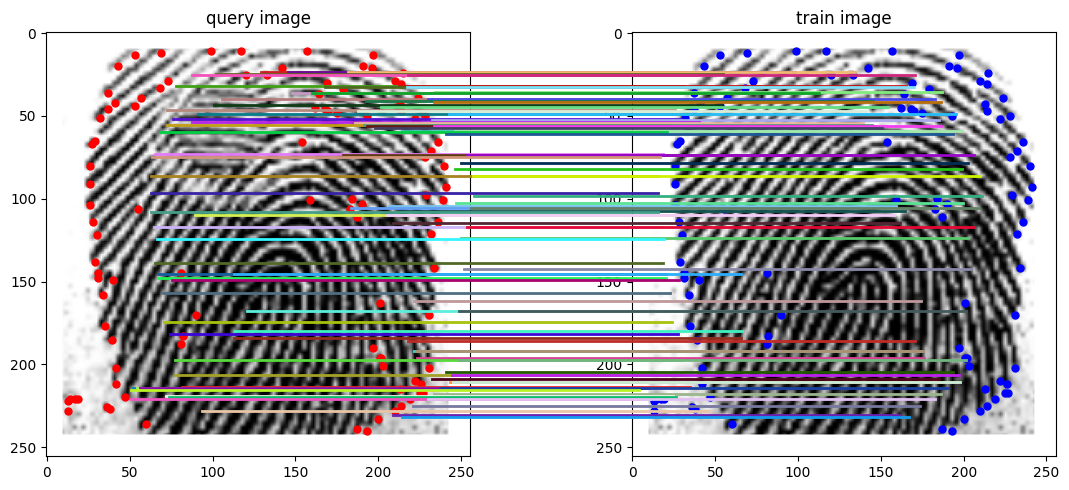

105.955322265625 100


In [13]:
dist, len_match = match_finger(feat_query, feat_train, 100, True, img_query=img_test, img_train=img_train)
print(dist, len_match)

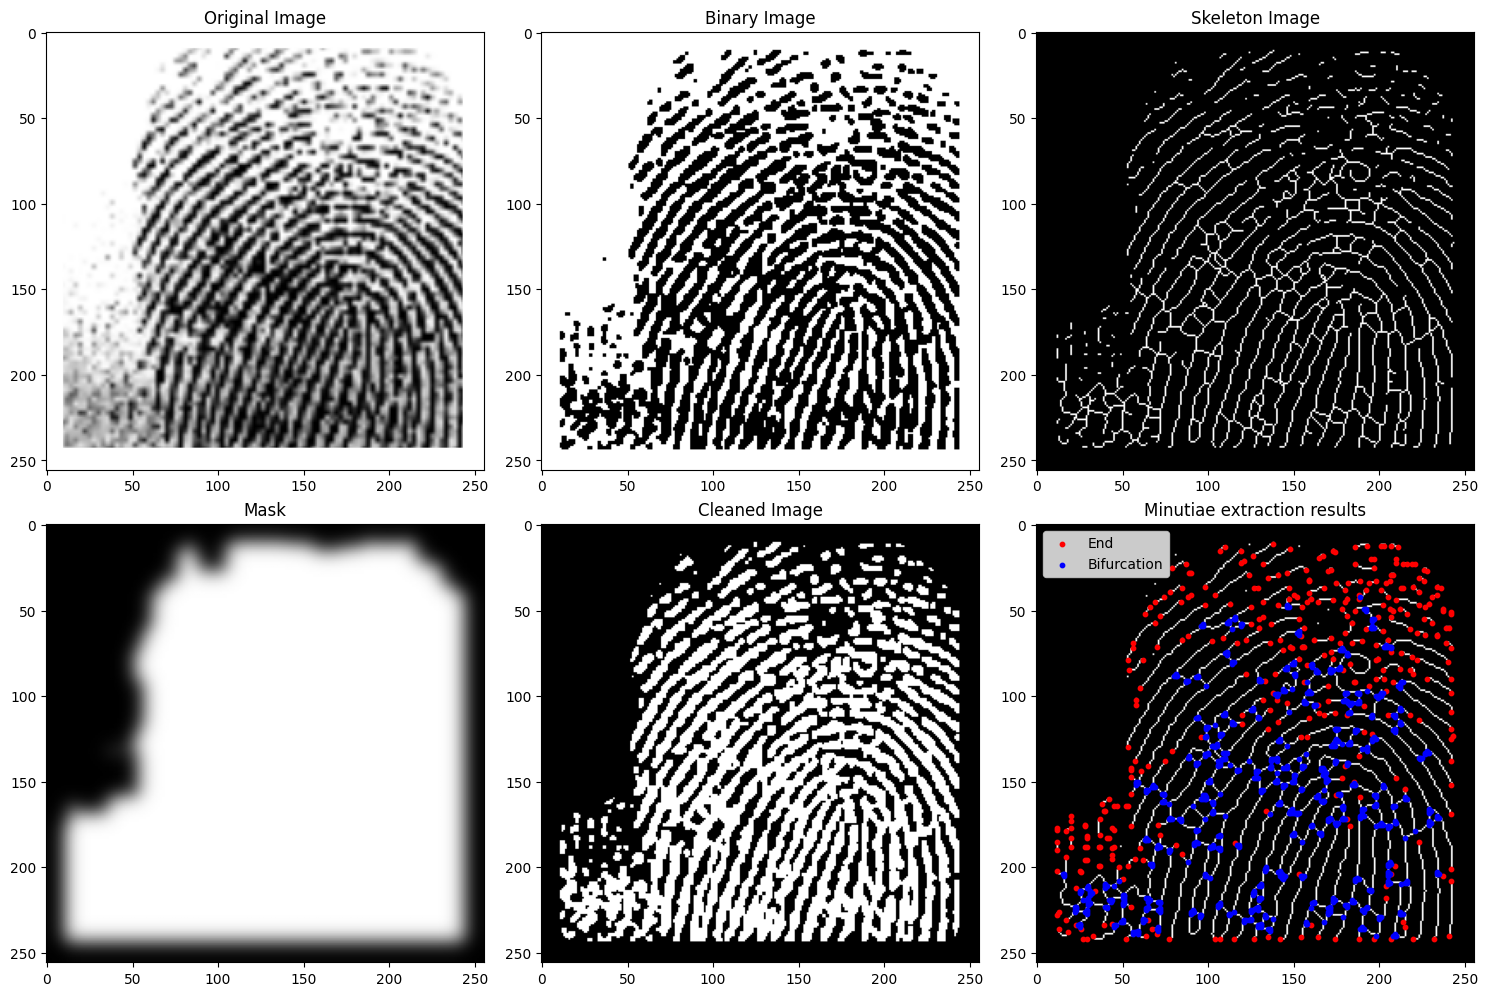

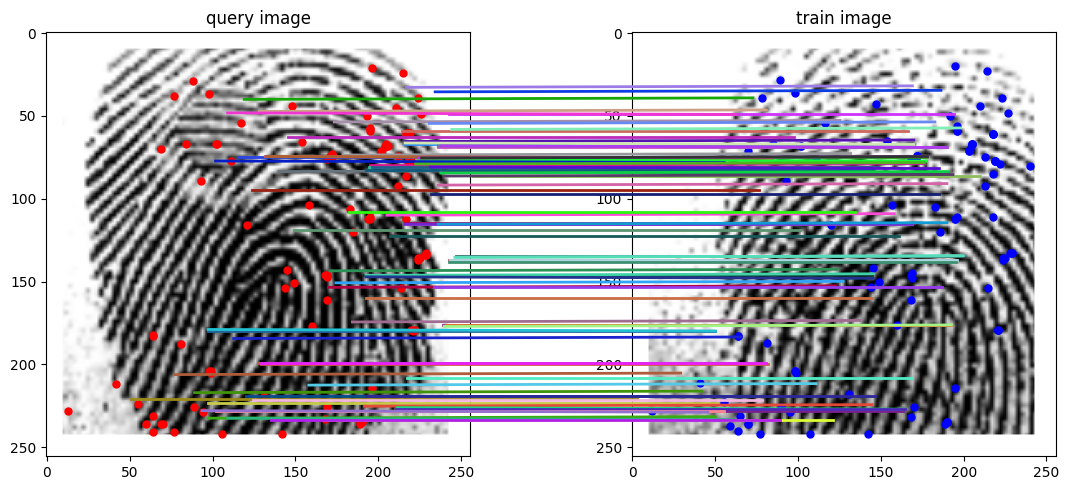

109.37833404541016 100


In [14]:
img_train2 = cv2.imread(list_train[1], 0)
# db_x_end, db_x_bif = get_fp_feature(img_train2, True)
db_x_end, db_x_bif = get_fp_feature(img_train2, flg_show=True)
feat_db_x = np.concatenate([db_x_end, db_x_bif]).astype(np.uint8)
dist, len_match = match_finger(feat_query, feat_db_x, 100, True, img_query=img_test, img_train=img_train2)
print(dist, len_match)

In [15]:
dict_result = {}

def get_feature(img_list):
    result = {}
    for img in tqdm(img_list):
        basename = os.path.basename(img)
        img2 = cv2.imread(img,0)
        end, bif = get_fp_feature(img2, False)
        feat = np.concatenate([end, bif]).astype(np.uint8)
        result[basename] = feat
    return result

In [16]:
feat_train = get_feature(list_train)

  0%|          | 0/477 [00:00<?, ?it/s]

In [17]:
feat_querys = get_feature(list_test2)

  0%|          | 0/1428 [00:00<?, ?it/s]

In [18]:
# def match_fingers():
#     percents = []
#     for basename in feat_querys.keys():
#         query_feat = feat_querys[basename]

#         max_score = 0
#         for basename_train in feat_db.keys():
#             train_feat = feat_db[basename_train]
#             _, len_match = match_finger(query_feat, train_feat, 2, False)
#             score = len_match / (len(query_feat) + len(train_feat))
#             if max_score < score:
#                 max_score = score
#         percents.append(max_score*100)
#     return percents

In [25]:
def match_fingers(feat_querys, feat_train_db):
    percents = []
    for basename in feat_querys.keys():
        query_feat = feat_querys[basename]

        max_score = 0
        for basename_train in feat_train_db.keys():
            train_feat = feat_train_db[basename_train]
            _, len_match = match_finger(query_feat, train_feat, max_points=100, flg_show=False)
            score = len_match / (len(query_feat) + len(train_feat))
            if max_score < score:
                max_score = score

        percents.append(max_score * 100)  # %화
    return percents


In [27]:
def calculate_acceptence(percents, threshold = 50):
    positive_count = 0
    for percent in percents:
        if percent > threshold:
            positive_count += 1

    return [positive_count, len(percents) - positive_count]

In [29]:
 # 1. 특징점 추출
# feat_train = get_feature(list_train)
# feat_querys = get_feature(list_test2)

# 2. 유사도 계산
%timeit percents = match_fingers(feat_querys, feat_train)

# 3. 통과 판단
positive_count, negative_count = calculate_acceptence(percents, threshold=40)
print("Accept:", positive_count, "Reject:", negative_count)


KeyboardInterrupt: 

In [20]:
# positive_count, negative_count = calculate_acceptence(len_match, 40)
# print(positive_count, negative_count) # 40 정도 되니까 거의 잘 통과하는 것 같다.

TypeError: 'int' object is not iterable

In [30]:
import multiprocessing
from functools import partial

#멀티프로세싱
def compute_percent(query_name, query_feat, feat_train_db):
    max_score = 0
    for train_name, train_feat in feat_train_db.items():
        _, len_match = match_finger(query_feat, train_feat, max_points=100, flg_show=False)
        score = len_match / (len(query_feat) + len(train_feat))
        if max_score < score:
            max_score = score
    return query_name, max_score * 100

def match_fingers_parallel(feat_querys, feat_train_db):
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        jobs = [
            pool.apply_async(compute_percent, (qname, qfeat, feat_train_db))
            for qname, qfeat in feat_querys.items()
        ]
        results = [job.get() for job in jobs]
    results.sort()  # query 이름 순 정렬
    return [score for _, score in results]


In [32]:
# 병렬 유사도 계산
%timeit percents = match_fingers_parallel(feat_querys, feat_train)

# 성능 평가
positive_count, negative_count = calculate_acceptence(percents, threshold=40)
print("Accept:", positive_count, "Reject:", negative_count)

KeyboardInterrupt: 

실행시간 비교

In [ ]:
# Serial 버전 (loop 기반)
%timeit match_fingers(feat_querys, feat_train)

In [ ]:
# Parallel 버전 (fast version)
%timeit match_fingers_parallel(feat_querys, feat_train)

### 성능평가

In [33]:
def build_results_df(feat_querys, feat_train_db, test_list, train_list):
    records = []

    for test_path in tqdm(test_list):
        test_file = os.path.basename(test_path)
        query_feat = feat_querys[test_file]

        for train_path in train_list:
            train_file = os.path.basename(train_path)
            train_feat = feat_train_db[train_file]

            dist, _ = match_finger(query_feat, train_feat, max_points=100, flg_show=False)

            records.append({
                "distance": dist,
                "test_file": test_file,
                "train_file": train_file
            })

    return pd.DataFrame(records)


In [34]:
def evaluate_metrics(results_df, threshold):
    """
    distance 기준으로 precision, recall, FAR, FRR, ACC 계산

    Args:
        results_df: pd.DataFrame, 컬럼에 ['distance', 'test_file', 'train_file']
        threshold: float, 동일한 지문으로 판단할 거리 임계값

    Returns:
        metrics: dict, 각 지표 저장
    """
    y_true = []  # 실제 동일한 지문 여부 (GT)
    y_pred = []  # distance 기반 예측

    for _, row in results_df.iterrows():
        test_id = os.path.basename(row["test_file"]).split('_')[0]
        train_id = os.path.basename(row["train_file"]).split('.')[0]
        y_true.append(1 if test_id == train_id else 0)
        y_pred.append(1 if row["distance"] < threshold else 0)

    from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Confusion matrix 기반 FAR, FRR 계산
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FAR = fp / (fp + tn + 1e-8)
    FRR = fn / (fn + tp + 1e-8)

    return {
        "Threshold": threshold,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "FAR": FAR,
        "FRR": FRR
    }


In [ ]:
results_df = build_results_df(feat_querys, feat_train, list_test2, list_train)

threshold = 0.35  # 예시
metrics = evaluate_metrics(results_df, threshold)
# print(metrics)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


In [59]:

# # 2) 각 이미지마다 get_fp_feature 로 끝점/분기점 추출 → 하나의 리스트로 모으기
# feat_query_list = []
# feat_train_list = []
# for img_q, img_t in zip(list_test2, list_train):
#     # get_fp_feature(img, flg_show=False) -> ([end_pts], [bif_pts])
#     q_end, q_bif = get_fp_feature(img_q, flg_show=False)
#     t_end, t_bif = get_fp_feature(img_t, flg_show=False)

#     # 두 종류의 특징점 합치기
#     feat_query_list.append(q_end + q_bif)
#     feat_train_list.append(t_end + t_bif)

# # 3) 이제 match_finger 로 반복 매칭
# results = []
# for img_q, img_t, fq, ft in zip(list_test2, list_train,
#                                 feat_query_list, feat_train_list):
#     dist, n_match = match_finger(
#         fq, ft,
#         max_points=100,
#         flg_show=False,       # 시각화 생략
#         img_query=img_q,
#         img_train=img_t
#     )
#     results.append({'distance': dist, 'matches': n_match})

# # 4) 결과 확인
# import pandas as pd
# df = pd.DataFrame(results)
# print(df)


# HARD

In [36]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [37]:
# 1) Dataset: 원본 ↔ 랜덤 변형 쌍 생성
class FingerprintPoseDataset(Dataset):
    def __init__(self, img_dir, transform=None, max_rot=30, max_tr=30):
        """
        img_dir: trainset의 지문 이미지가 들어 있는 폴더
        transform: torchvision.transforms (resize, toTensor 등)
        max_rot: 랜덤 회전 각도 범위 ±max_rot (deg)
        max_tr: 랜덤 이동 픽셀 범위 ±max_tr (both x,y)
        """
        self.paths = sorted(glob(os.path.join(img_dir, "*.BMP")))
        self.transform = transform
        self.max_rot = max_rot
        self.max_tr  = max_tr

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # 1) 원본 이미지 읽기 (grayscale)
        img = cv2.imread(self.paths[idx], cv2.IMREAD_GRAYSCALE)
        h, w = img.shape

        # 2) 랜덤 pose 생성
        theta = np.random.uniform(-self.max_rot, self.max_rot)
        tx    = np.random.uniform(-self.max_tr, self.max_tr)
        ty    = np.random.uniform(-self.max_tr, self.max_tr)

        # 3) Affine 변환 행렬 계산
        M = cv2.getRotationMatrix2D((w/2, h/2), theta, 1.0)
        M[:,2] += [tx, ty]  # translation 추가
        img_warp = cv2.warpAffine(img, M, (w, h), borderValue=255)

        # 4) 두 이미지를 2채널로 stacking
        pair = np.stack([img, img_warp], axis=2)  # H×W×2

        # 5) torchvision 변환 (Tensor, 정규화)
        if self.transform:
            pair = self.transform(pair)

        # 6) label: 회전, 이동을 각각 정규화해서 regression target으로
        # θ: deg → rad으로 바꾸고   / max_rot 으로 나눠서 [-1,1] 범위로
        # tx, ty: 픽셀 → max_tr 로 나눠서 [-1,1]
        label = np.array([
            theta / self.max_rot,
            tx    / self.max_tr,
            ty    / self.max_tr
        ], dtype=np.float32)

        return pair, label


In [38]:
# 2) Model: 간단한 Siamese‐style CNN → FC → 3‐dim 회귀
class PoseSiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 공유 CNN 백본 (2채널 입력)
        self.backbone = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=5, stride=2, padding=2),  # H/2×W/2×16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2), # H/4×W/4×32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # H/8×W/8×64
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # 1×1×64
            nn.Flatten(),             # 64
        )
        # regressor head
        self.regressor = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3),        # [θ_norm, tx_norm, ty_norm]
            # no activation → MSE loss가 직접 회귀
        )

    def forward(self, x):
        f = self.backbone(x)
        out = self.regressor(f)
        return out



In [39]:
# 3) Training loop

def train_pose_model(img_dir, epochs=20, batch_size=16, lr=1e-3):
    # 1) Dataset / DataLoader
    transform = transforms.Compose([
        transforms.ToTensor(),                     # H×W×2 → 2×H×W (0~255→0~1)
        transforms.Normalize([0.5]*2, [0.5]*2)     # [-1,1] 범위로
    ])
    ds = FingerprintPoseDataset(img_dir, transform=transform)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    # 2) Model / Optimizer / Loss
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PoseSiameseNet().to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # 3) 학습
    for ep in range(epochs):
        running_loss = 0.0
        for pairs, labels in tqdm(dl, desc=f"Epoch {ep+1}/{epochs}"):
            pairs  = pairs.to(device)   # (B,2,H,W)
            labels = labels.to(device)  # (B,3)

            preds = model(pairs)        # (B,3)
            loss  = loss_fn(preds, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item() * pairs.size(0)

        epoch_loss = running_loss / len(ds)
        print(f"[{ep+1}/{epochs}] Loss: {epoch_loss:.4f}")

    return model


In [40]:
# 4) Inference: test1 셋에 적용해보기
def infer_on_test1(model, test1_dir, max_rot=30, max_tr=30):
    device = next(model.parameters()).device
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5]*2, [0.5]*2)
    ])

    for path in sorted(glob(os.path.join(test1_dir, "*.BMP"))):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # query=원본, train=로테이션+이동된 것
        train_path = path.replace("test1", "train_ref")

        img_train = cv2.imread(train_path, cv2.IMREAD_GRAYSCALE)

        pair = np.stack([img_train, img], axis=2)
        x = transform(pair).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(x).cpu().numpy()[0]

        theta_pred = out[0] * max_rot
        tx_pred    = out[1] * max_tr
        ty_pred    = out[2] * max_tr

        print(f"{os.path.basename(path)} → θ={theta_pred:.1f}°, t=[{tx_pred:.1f},{ty_pred:.1f}]")


In [41]:
model = train_pose_model("/content/drive/MyDrive/EWHA/train/train_ref", epochs=30, batch_size=32, lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/30: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


[1/30] Loss: 0.3233


Epoch 2/30: 100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


[2/30] Loss: 0.3232


Epoch 3/30: 100%|██████████| 15/15 [00:15<00:00,  1.07s/it]


[3/30] Loss: 0.3220


Epoch 4/30: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


[4/30] Loss: 0.3274


Epoch 5/30: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


[5/30] Loss: 0.3248


Epoch 6/30: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


[6/30] Loss: 0.3059


Epoch 7/30: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


[7/30] Loss: 0.2905


Epoch 8/30: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


[8/30] Loss: 0.2810


Epoch 9/30: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


[9/30] Loss: 0.2685


Epoch 10/30: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


[10/30] Loss: 0.2375


Epoch 11/30: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


[11/30] Loss: 0.2142


Epoch 12/30: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


[12/30] Loss: 0.2035


Epoch 13/30: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


[13/30] Loss: 0.1848


Epoch 14/30: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


[14/30] Loss: 0.1746


Epoch 15/30: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


[15/30] Loss: 0.1711


Epoch 16/30: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


[16/30] Loss: 0.1516


Epoch 17/30: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


[17/30] Loss: 0.1595


Epoch 18/30: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


[18/30] Loss: 0.1581


Epoch 19/30: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


[19/30] Loss: 0.1507


Epoch 20/30: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


[20/30] Loss: 0.1454


Epoch 21/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


[21/30] Loss: 0.1454


Epoch 22/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


[22/30] Loss: 0.1355


Epoch 23/30: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


[23/30] Loss: 0.1348


Epoch 24/30: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


[24/30] Loss: 0.1388


Epoch 25/30: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


[25/30] Loss: 0.1173


Epoch 26/30: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


[26/30] Loss: 0.1263


Epoch 27/30: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


[27/30] Loss: 0.1070


Epoch 28/30: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


[28/30] Loss: 0.1072


Epoch 29/30: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


[29/30] Loss: 0.1117


Epoch 30/30: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]

[30/30] Loss: 0.1050


In [42]:
infer_on_test1(model, "/content/drive/MyDrive/EWHA/test1")

In [43]:
import numpy as np

def compute_metrics(distances, labels, threshold):
    """
    distances : 1D array-like of float — 매칭 결과로 나온 평균 거리
    labels    : 1D array-like of int   — 1이면 진본(genuine), 0이면 거짓(impostor)
    threshold : float                  — 거리를 이 값 이하면 “매칭”으로 판단

    Returns: dict with Precision, Recall, FAR, FRR, ACC
    """
    distances = np.asarray(distances)
    labels    = np.asarray(labels)

    # 예측: distance <= threshold → positive(match), else negative(non-match)
    preds = (distances <= threshold).astype(int)

    # 진본(genuine) / 거짓(impostor) 인덱스
    genuine_idx  = (labels == 1)
    impostor_idx = (labels == 0)

    # TP, FN, FP, TN 계산
    TP = np.logical_and(preds == 1, genuine_idx).sum()
    FN = np.logical_and(preds == 0, genuine_idx).sum()
    FP = np.logical_and(preds == 1, impostor_idx).sum()
    TN = np.logical_and(preds == 0, impostor_idx).sum()

    # Metrics
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    Recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    FAR       = FP / (FP + TN) if (FP + TN) > 0 else 0.0    # False Acceptance Rate
    FRR       = FN / (TP + FN) if (TP + FN) > 0 else 0.0    # False Rejection Rate
    ACC       = (TP + TN) / (TP + TN + FP + FN)

    return {
        'threshold': threshold,
        'Precision': Precision,
        'Recall':    Recall,
        'FAR':       FAR,
        'FRR':       FRR,
        'ACC':       ACC,
        'TP':        TP,
        'TN':        TN,
        'FP':        FP,
        'FN':        FN
    }

In [46]:
# import random

# train_path_root = "/content/drive/MyDrive/EWHA/train/train_ref"
# test1_path_root = "/content/drive/MyDrive/EWHA/test1/test"

# list_train = sorted(glob(os.path.join(train_path_root, "*.BMP")))
# list_test1 = sorted(glob(os.path.join(test1_path_root, "*.BMP")))

# # 2) 미리 특징 리스트 생성
# feat_query_list = []
# feat_train_list = []

# for test_fp, train_fp in zip(list_test1, list_train):
#     img_q = cv2.imread(test_fp,  cv2.IMREAD_GRAYSCALE)
#     img_t = cv2.imread(train_fp, cv2.IMREAD_GRAYSCALE)

#     # get_fp_feature 는 (end_pts, bif_pts) 튜플 반환
#     q_end, q_bif = get_fp_feature(img_q, flg_show=False)
#     t_end, t_bif = get_fp_feature(img_t, flg_show=False)

#     # 끝점 + 분기점 결합
#     feat_query_list.append(q_end + q_bif)
#     feat_train_list.append(t_end + t_bif)

# # 이 지점에서 반드시 리스트가 채워져야 합니다!
# print("After collect —", len(feat_query_list), len(feat_train_list))

# # 3) 매칭 및 거리 계산
# distances = []
# labels    = []

# N = len(feat_query_list)

# for i in range(N):
#     # genuine pair
#     fq = feat_query_list[i]
#     ft = feat_train_list[i]

#     d_true, _ = match_finger(fq, ft, max_points=100, flg_show=False)
#     distances.append(d_true)
#     labels.append(1)

#     # impostor pair
#     j = random.choice([k for k in range(N) if k!=i])
#     ft_neg = feat_train_list[j]
#     d_false, _ = match_finger(fq, ft_neg, max_points=100, flg_show=False)
#     distances.append(d_false)
#     labels.append(0)

# # 4) 메트릭 계산
# threshold = 30.0
# metrics = compute_metrics(distances, labels, threshold)

# # 5) 결과 출력
# print("Threshold =", threshold)
# for k, v in metrics.items():
#     print(f"{k:>8s} : {v:.4f}")

# # 6) 결과 DataFrame
# df = pd.DataFrame({'distance': distances, 'label': labels})
# print(df.head())


After collect — 477 477


KeyboardInterrupt: 

In [48]:
train_path_root = "/content/drive/MyDrive/EWHA/train/train_ref"
test1_path_root = "/content/drive/MyDrive/EWHA/test1/test"

list_train = sorted(glob(os.path.join(train_path_root, "*.BMP")))
list_test1 = sorted(glob(os.path.join(test1_path_root, "*.BMP")))

# 2) 미리 특징 리스트 생성
feat_query_list = []
feat_train_list = []

for test_fp, train_fp in zip(list_test1, list_train):
    img_q = cv2.imread(test_fp,  cv2.IMREAD_GRAYSCALE)
    img_t = cv2.imread(train_fp, cv2.IMREAD_GRAYSCALE)

    # get_fp_feature 는 (end_pts, bif_pts) 튜플 반환
    q_end, q_bif = get_fp_feature(img_q, flg_show=False)
    t_end, t_bif = get_fp_feature(img_t, flg_show=False)

    # 끝점 + 분기점 결합
    feat_query_list.append(q_end + q_bif)
    feat_train_list.append(t_end + t_bif)

# 이 지점에서 반드시 리스트가 채워져야 합니다!
print("After collect —", len(feat_query_list), len(feat_train_list))

# 3) 매칭 및 거리 계산
distances = []
labels    = []

N = len(feat_query_list)
print("N images:", N)

for i in range(N):
    # genuine pair
    fq = feat_query_list[i]
    ft = feat_train_list[i]

    # 디버그: 특징점 개수 확인
    # print(f"\n=== Sample {i} ===")
    # print("  # query minutiae:", len(fq))
    # print("  # train minutiae:", len(ft))

    d_true, _ = match_finger(fq, ft, max_points=100, flg_show=False)
    print("  genuine dist:", d_true)
    distances.append(d_true)
    labels.append(1)

    # impostor pair
    j = random.choice([k for k in range(N) if k!=i])
    ft_neg = feat_train_list[j]
    d_false, _ = match_finger(fq, ft_neg, max_points=100, flg_show=False)
    print("  impostor dist:", d_false)
    distances.append(d_false)
    labels.append(0)

# 루프 빠져나온 뒤에도 확인
print("\n>>> Collected distances:", len(distances))
print("    first 10 distances:", distances[:10])
print("    labels length:", len(labels))
print("    first 10 labels   :", labels[:10])

# 4) 메트릭 계산
threshold = 30.0
metrics = compute_metrics(distances, labels, threshold)

# 5) 결과 출력
print("Threshold =", threshold)
for k, v in metrics.items():
    print(f"{k:>8s} : {v:.4f}")

# 6) 결과 DataFrame
df = pd.DataFrame({'distance': distances, 'label': labels})
print(df.head())


After collect — 477 477
N images: 477
  genuine dist: 103.40354919433594
  impostor dist: 101.98532104492188
  genuine dist: 111.30265045166016
  impostor dist: 114.48651123046875
  genuine dist: 105.42301177978516
  impostor dist: 107.93206024169922
  genuine dist: 93.23236846923828
  impostor dist: 90.36805725097656
  genuine dist: 106.2891845703125
  impostor dist: 106.63031768798828
  genuine dist: 103.53758239746094
  impostor dist: 103.03977966308594
  genuine dist: 106.7542953491211
  impostor dist: 118.62950897216797
  genuine dist: 99.87062072753906
  impostor dist: 100.56056213378906
  genuine dist: 86.11976623535156
  impostor dist: 97.77245330810547
  genuine dist: 99.13956451416016
  impostor dist: 99.05122375488281
  genuine dist: 97.48504638671875
  impostor dist: 97.10889434814453
  genuine dist: 105.76171875
  impostor dist: 108.10040283203125
  genuine dist: 99.54348754882812
  impostor dist: 109.0315170288086
  genuine dist: 104.60506439208984
  impostor dist: 112.02

NameError: name 'pd' is not defined

In [49]:
import pandas as pd
# 6) 결과 DataFrame
df = pd.DataFrame({'distance': distances, 'label': labels})
print(df.head())

     distance  label
0  103.403549      1
1  101.985321      0
2  111.302650      1
3  114.486511      0
4  105.423012      1


In [50]:
# 4) 메트릭 계산
threshold = 40.0
metrics = compute_metrics(distances, labels, threshold)

# 5) 결과 출력
print("Threshold =", threshold)
for k, v in metrics.items():
    print(f"{k:>8s} : {v:.4f}")

Threshold = 40.0
threshold : 40.0000
Precision : 0.0000
  Recall : 0.0000
     FAR : 0.0000
     FRR : 1.0000
     ACC : 0.5000
      TP : 0.0000
      TN : 477.0000
      FP : 0.0000
      FN : 477.0000


In [51]:
# 4) 메트릭 계산
threshold = 80.0
metrics = compute_metrics(distances, labels, threshold)

# 5) 결과 출력
print("Threshold =", threshold)
for k, v in metrics.items():
    print(f"{k:>8s} : {v:.4f}")

Threshold = 80.0
threshold : 80.0000
Precision : 1.0000
  Recall : 0.0021
     FAR : 0.0000
     FRR : 0.9979
     ACC : 0.5010
      TP : 1.0000
      TN : 477.0000
      FP : 0.0000
      FN : 476.0000


In [53]:
# 4) 메트릭 계산
threshold = 100.0
metrics = compute_metrics(distances, labels, threshold)

# 5) 결과 출력
print("Threshold =", threshold)
for k, v in metrics.items():
    print(f"{k:>8s} : {v:.4f}")

Threshold = 100.0
threshold : 100.0000
Precision : 0.6465
  Recall : 0.5597
     FAR : 0.3061
     FRR : 0.4403
     ACC : 0.6268
      TP : 267.0000
      TN : 331.0000
      FP : 146.0000
      FN : 210.0000


In [58]:
# 4) 메트릭 계산
threshold = 105.0
metrics = compute_metrics(distances, labels, threshold)

# 5) 결과 출력
print("Threshold =", threshold)
for k, v in metrics.items():
    print(f"{k:>8s} : {v:.4f}")

Threshold = 105.0
threshold : 105.0000
Precision : 0.5684
  Recall : 0.7925
     FAR : 0.6017
     FRR : 0.2075
     ACC : 0.5954
      TP : 378.0000
      TN : 190.0000
      FP : 287.0000
      FN : 99.0000
